<span style="display:block;text-align:center;margin-right:105px"><img src="../media/logos/hacks-logo.png" width="200"/></span>

## Table of Contents

<ul>
    <li><a href='#Dependencies'>Dependencies</a></li>
    <li><a href='#Setup-/-Preparatory-Steps'>Setup / Preparatory Steps</a>
        <ul style='margin-top: 0em;'>
            <li><a href='#Initializing-Agents-Network'>Initializing Agents Network</a></li>
        </ul>
    </li>
    <li><a href='#Modelling'>Modelling</a>
        <ol style='margin-top: 0em;'>
            <li><a href='#1.-State-Variables'>State Variables</a></li>
            <li><a href='#2.-System-Parameters'>System Parameters</a></li>
            <li><a href='#3.-Policy-Functions'>Policy Functions</a></li>
            <li><a href='#4.-State-Update-Functions'>State Update Functions</a></li>
            <li><a href='#5.-Partial-State-Update-Blocks'>Partial State Update Blocks</a></li>
        </ol>
    </li>
    <li><a href='#Simulation'>Simulation</a>
        <ol style='margin-top: 0em;' start="6">
            <li><a href='#6.-Configuration'>Configuration</a></li>
            <li><a href='#7.-Execution'>Execution</a></li>
            <li><a href='#8.-Output-Preparation'>Output Preparation</a></li>
            <li><a href='#9.-Analysis'>Analysis</a></li>
        </ol>
    </li>
</ul>

---

# Dependencies

In [1]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

In [2]:
# Additional dependencies

# For networks
import networkx as nx

# For analytics
import numpy as np

# For visualization
from matplotlib import pyplot as plt

# Setup / Preparatory Steps

## Initializing Agents Network

In [3]:
# Generate a empty directional graph
G = nx.MultiDiGraph()

# Number of agents
NUMBER_AGENTS = 10

# Max / Min balance for each agent
MAX_AGENT_BALANCE = 2000
MIN_AGENT_BALANCE = 1000

for agent in range(NUMBER_AGENTS):
    # Generate random balance bounded between MIN_AGENT_BALANCE and MAX_AGENT_BALANCE
    agent_balance = MIN_AGENT_BALANCE + np.random.rand() * (MAX_AGENT_BALANCE - MIN_AGENT_BALANCE)
    
    # Add agent to the graph
    G.add_node(agent, balance=agent_balance)

print("agents_network:")
print(G.nodes(data=True))

agents_network:
[(0, {'balance': 1194.1015993610738}), (1, {'balance': 1744.067353228579}), (2, {'balance': 1319.2285306804179}), (3, {'balance': 1343.4921278418767}), (4, {'balance': 1832.6208480478863}), (5, {'balance': 1843.609602318998}), (6, {'balance': 1295.9790612131849}), (7, {'balance': 1623.6981241043727}), (8, {'balance': 1808.975657700642}), (9, {'balance': 1548.935166735794})]


# Modelling

## 1. State Variables

In [4]:
initial_state = {
    'agents_network': G
}

print(f"Initial State: {initial_state}")

Initial State: {'agents_network': <networkx.classes.multidigraph.MultiDiGraph object at 0x133260880>}


## 2. System Parameters

In [5]:
system_params = {
    # Pair-wise interaction probability
    'interaction_probability': [0.05], 
    
    # Fraction of the agent balance to stake
    'balance_fraction_to_stake': [0.2] 
}

## 3. Policy Functions

In [6]:
def p_interact(params, substep, state_history, previous_state):
    """
    Control agent interactions.
    """
    
    # Variables and parameters to be used
    G = previous_state['agents_network']
    interaction_probability = params['interaction_probability']
    balance_fraction_to_transfer = params['balance_fraction_to_stake']
    
    # List of agent transactions
    transactions = []
    
    for agent_1 in G.nodes:
        for agent_2 in G.nodes:
            
            # Skip self-transactions
            if agent_1 == agent_2:
                continue
            else:
                # Determine if the agents are going to interact
                will_interact = (np.random.rand() < interaction_probability)
                
                if will_interact is True:
                    # Get agent balances
                    agent_1_balance = G.nodes[agent_1]['balance']
                    agent_2_balance = G.nodes[agent_2]['balance']
                    
                    
                    # Get exchange values
                    agent_1_exchange = agent_1_balance * balance_fraction_to_transfer
                    agent_2_exchange = agent_2_balance * balance_fraction_to_transfer
                    
                    # Set the final exchange as being the minimum of the two                
                    exchange = min(agent_1_exchange, agent_2_exchange)
                    
                    # Generate a transaction
                    transaction = {'source': agent_1,
                                   'destination': agent_2,
                                   'value': exchange}
                    
                    transactions.append(transaction)
                else:
                    continue
                    
    # Return agent interactions
    return {'transactions': transactions}

## 4. State Update Functions

In [7]:
def s_agents_network(params, substep, state_history, previous_state, policy_input):
    # Retrieve used variables and policy inputs
    G_new = previous_state['agents_network'].copy()
    transactions = policy_input['transactions']
    
    for transaction in transactions:
        # Retrieve transaction details
        source = transaction['source']
        destination = transaction['destination']
        amount = transaction['value']
        
        # Add / remove the amount from the agents balance
        G_new.nodes[source]['balance'] -= amount
        G_new.nodes[destination]['balance'] += amount
        
        # Add the transaction as being a graph edge
        G_new.add_edge(source, destination, amount=amount)
        
    return ('agents_network', G_new)

## 5. Partial State Update Blocks

In [8]:
partial_state_update_blocks = [
    {   
        # Configure the model Policy Functions
        'policies': {
            'p_interact': p_interact
        },
        # Configure the model State Update Functions
        'variables': {
            'agents_network': s_agents_network
        }
    }
]

# Simulation

## 6. Configuration

In [9]:
sim_config = config_sim({
    "N": 1, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(300), # the number of timesteps the simulation will run for
    "M": system_params # the parameters of the system
})

In [10]:
del configs[:] # Clear any prior configs

In [11]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## 7. Execution

In [12]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (300, 2, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.45s


## 8. Output Preparation

In [13]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(5)

,agents_network,simulation,subset,run,substep,timestep,interaction_probability,balance_fraction_to_stake
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,0,0,0.05,0.2
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,1,0.05,0.2
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,2,0.05,0.2
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,3,0.05,0.2
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,4,0.05,0.2


## 9. Analysis

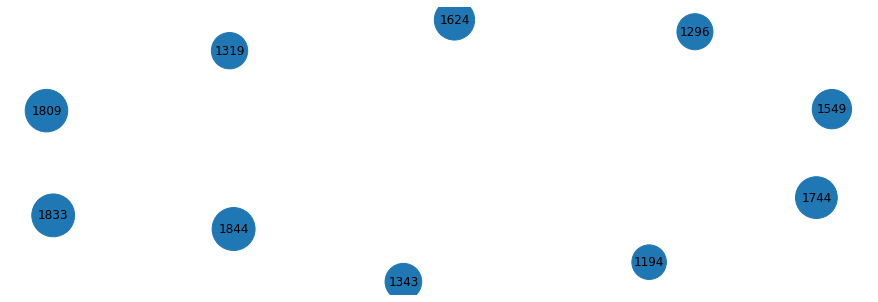

In [14]:
# Get the agents network at the beginning
G = df.agents_network.iloc[0]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()

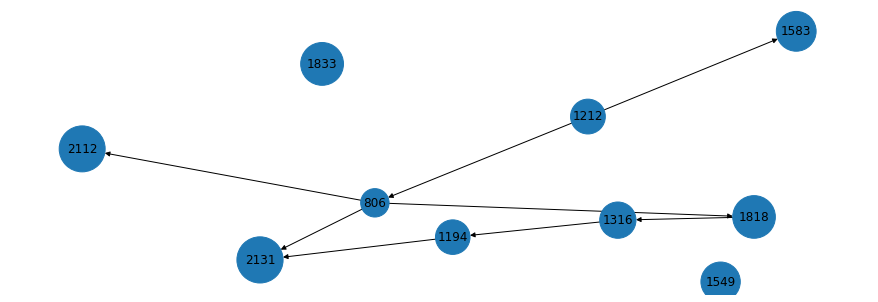

In [15]:
# Get the agents network after 2 rounds
G = df.agents_network.iloc[2]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()

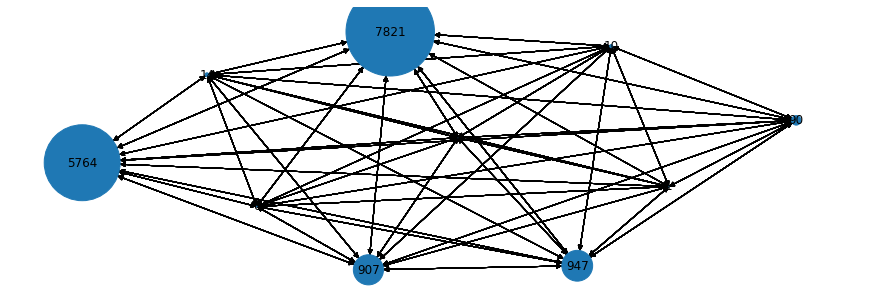

In [16]:
# Get the agents network at the end
G = df.agents_network.iloc[-1]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()